In [10]:
from crocoddyl import *
import pinocchio as pin
import numpy as np

robot = loadBorinotArm()
robot.initViewer(loadModel=True)

q0 = [3.14, 0]
robot.q0.flat = q0
robot.framesForwardKinematics(robot.q0)
robot.display(robot.q0)

IDX_LINK1 = robot.model.getFrameId('link1', pin.FrameType.BODY)
IDX_LINK2 = robot.model.getFrameId('link2', pin.FrameType.BODY)
Mlink1 = robot.data.oMf[IDX_LINK1]
Mlink2 = robot.data.oMf[IDX_LINK2]

target_pos  = np.array([0,0,0.3])
target_quat = pin.Quaternion(1, 0, 0, 0)
target_quat.normalize()

Mref = pin.SE3()
Mref.translation = target_pos.reshape(3,1)
Mref.rotation = target_quat.matrix()

#robot.viewer.gui.addXYZaxis('world/framelink1', [1., 0., 0., 1.], .005, 0.05)
#robot.viewer.gui.addXYZaxis('world/framelink2', [1., 0., 0., 1.], .005, 0.05)
#robot.viewer.gui.addXYZaxis('world/frameref', [1., 0., 0., 1.], .005, 0.05)

#robot.viewer.gui.applyConfiguration('world/framelink1', pin.se3ToXYZQUATtuple(Mlink1))
#robot.viewer.gui.applyConfiguration('world/framelink2', pin.se3ToXYZQUATtuple(Mlink2))
#robot.viewer.gui.applyConfiguration('world/frameref', pin.se3ToXYZQUATtuple(Mref))

robot.viewer.gui.refresh()

In [11]:
import time 
dt = 0.01
t = np.arange(0,10,dt)
q0 = np.array([[1,0]]).T

q = q0
q_d = np.zeros([2,1])
q_dd = np.zeros([2,1])

In [12]:
nle = np.zeros([2,1])
for i in range(len(t)):
    pin.computeAllTerms(robot.model, robot.data, q, q_d)
    M = robot.data.M
    Minv = np.linalg.inv(M)
    r = np.zeros([2,1])
    tau = np.zeros([2,1])
    nle[:,0] = m2a(robot.data.nle)    
    r[:] = tau - nle
    q_dd = np.dot(Minv, r)
    q = q + q_d*dt + q_dd*dt**2
    q_d = q_d + q_dd*dt
    #pin.forwardKinematics(robot.model, robot.data, q, q_d)
    robot.display(q)
    time.sleep(dt)

KeyboardInterrupt: 

In [31]:
state = StatePinocchio(robot.model)

xRegCost = CostModelState(robot.model, state, ref=state.zero(), nu=1)
uRegCost = CostModelControl(robot.model, nu = 1)
xPendCost = CostModelDoublePendulum(robot.model, 
                                    frame=state, 
                                    ref=state.zero, 
                                    nu=1,
                                    activation=ActivationModelWeightedQuad(np.array([1,1,1,1]+[0.1]*2))) 

runningCostModel = CostModelSum(robot.model, nu=1)
terminalCostModel = CostModelSum(robot.model, nu=1)

# runningCostModel.addCost(name="regx", weight=1e-6, cost=xRegCost)
runningCostModel.addCost(name="regu", weight=1e-3, cost=uRegCost)
runningCostModel.addCost(name="pend", weight=0.1, cost=xPendCost)
terminalCostModel.addCost(name="ori2", weight=1e5, cost=xPendCost)

In [32]:
actModel = ActuationModelDoublePendulum(robot.model)
runningModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, runningCostModel))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, terminalCostModel))

In [33]:
# Defining the time duration for running action models and the terminal one
dt = 1e-2
runningModel.timeStep = dt

T = 100
x0 = np.array([3.14, 0, 0., 0. ])
problem = ShootingProblem(x0, [runningModel] * T, terminalModel)

In [34]:
# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

us0 = np.zeros([T,1])
us0 = us0 + 4
xs0 = [problem.initialState+0.1]*len(ddp.models())

#ddp.solve(init_xs=xs0,init_us=us0,maxiter=100)
ddp.solve(maxiter=150)

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  1.23424e+03  2.76233e+02  -3.48552e+04  1.00000e-09  1.00000e-09   0.2500     0
   1  1.01544e+03  1.00134e+05  2.35628e+03  1.00000e-09  1.00000e-09   0.2500     0
   2  9.16455e+02  1.83154e+05  1.89208e+03  1.00000e-09  1.00000e-09   0.1250     0
   3  7.57330e+02  1.87571e+05  1.52565e+03  1.00000e-09  1.00000e-09   0.2500     0
   4  6.44777e+02  1.44015e+05  1.35155e+03  1.00000e-09  1.00000e-09   0.2500     0
   5  5.27047e+02  8.60324e+04  9.96662e+02  1.00000e-09  1.00000e-09   0.1250     0
   6  4.50095e+02  6.75230e+04  7.74202e+02  1.00000e-09  1.00000e-09   0.1250     0
   7  4.00431e+02  1.80157e+05  5.83294e+02  1.00000e-09  1.00000e-09   0.1250     0
   8  3.83728e+02  4.99068e+05  4.44340e+02  1.00000e-09  1.00000e-09   0.2500     0
   9  3.10166e+02  8.60093e+05  3.81490e+02  1.00000e-09  1.00000e-09   0.2500     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  2.98238

([array([3.14, 0.  , 0.  , 0.  ]),
  array([  2.48619666,   1.26799443, -65.38033368, 126.79944273]),
  array([  2.27233527,   1.66634287, -21.3861392 ,  39.83484469]),
  array([  2.08671921,   2.00420597, -18.56160577,  33.78630934]),
  array([  1.92029401,   2.29883584, -16.64252052,  29.46298714]),
  array([  1.76708298,   2.56217061, -15.32110304,  26.33347696]),
  array([  1.62087626,   2.80764516, -14.62067198,  24.54745521]),
  array([  1.47442262,   3.05190744, -14.64536354,  24.426228  ]),
  array([  1.3206873 ,   3.3127518 , -15.37353206,  26.08443616]),
  array([  1.15679491,   3.60189934, -16.38923966,  28.91475425]),
  array([  0.98681691,   3.91567307, -16.99779944,  31.37737266]),
  array([  0.8222342 ,   4.23005108, -16.45827131,  31.43780118]),
  array([  0.67743907,   4.512543  , -14.47951315,  28.24919166]),
  array([  0.55775724,   4.74885966, -11.96818306,  23.6316665 ]),
  array([ 0.46044418,  4.94217678, -9.73130511, 19.33171132]),
  array([ 0.38132951,  5.099636

In [36]:
displayTrajectory(robot, ddp.xs, runningModel.timeStep)

In [49]:
import time 
dt = 0.01
t = np.arange(0,1,dt)
q0 = np.array([[3.14,0]]).T

q = q0
q_d = np.zeros([2,1])
q_dd = np.zeros([2,1])

In [50]:
robot.display(q)

In [51]:
nle = np.zeros([2,1])
for i in range(len(t)):
    pin.computeAllTerms(robot.model, robot.data, q, q_d)
    M = robot.data.M
    Minv = np.linalg.inv(M)
    r = np.zeros([2,1])
    tau = np.zeros([2,1])
    tau[1,0] = ddp.us[i]
    nle[:,0] = m2a(robot.data.nle)    
    r[:] = tau - nle
    q_dd = np.dot(Minv, r)
    q = q + q_d*dt + q_dd*dt**2
    q_d = q_d + q_dd*dt
    #pin.forwardKinematics(robot.model, robot.data, q, q_d)
    robot.display(q)
    time.sleep(dt)

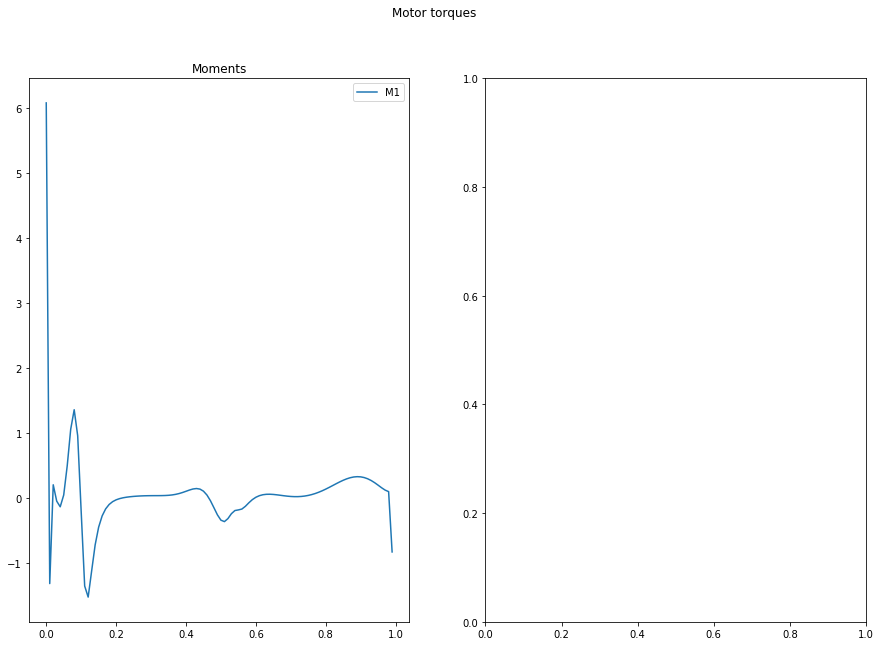

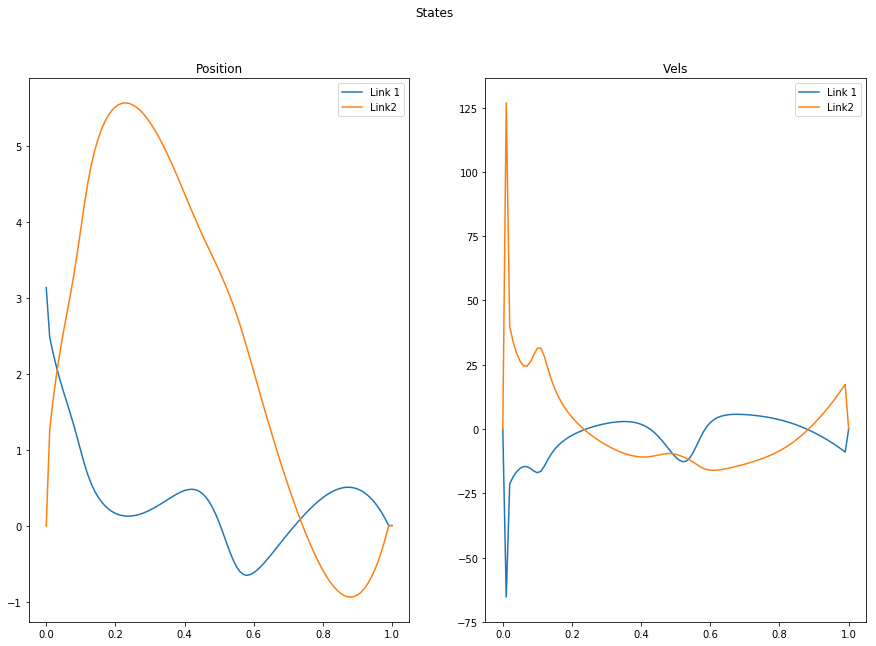

In [37]:
import numpy as np
import matplotlib.pyplot as plt

control = np.vstack(ddp.us)
t = np.arange(0,T*dt, dt)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('Motor torques')
# axs[0].plot(t,control[:,0], t,control[:,1])
axs[0].plot(t,control[:,0])
axs[0].set_title('Moments')
axs[0].legend(['M1','M2'])

t_state = np.append(t, t[-1]+dt)
state = np.vstack(ddp.xs)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('States')
axs[0].plot(t_state,state[:,0], t_state, state[:,1])
axs[0].set_title('Position')
axs[0].legend(['Link 1','Link2'])
axs[1].plot(t_state,state[:,2], t_state, state[:,3])
axs[1].set_title('Vels')
axs[1].legend(['Link 1','Link2'])

In [ ]:
H = np.zeros([6, 4])
c1 = 1
c2 = 1
s1 = 0
s2 = 0
H[:2,:2] = np.diag([c1**2-s1**2, c2**2-s2**2])
H[2:4,:2] = np.diag([s1**2+(1-c1)*c1, s2**2+(1-c2)*c2])
H[4:6,2:4] = np.diag([1,1])
weights = np.array([10]*4 + [0.1]*2)
Axx = weights[:, None]
Lxx = np.dot(H.T, Axx)
Lxx
L = np.zeros([4,4])
L[:,:] = np.diag([Lxx[0,0], Lxx[1,0], Lxx[2,0], Lxx[3,0]])
L